In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, ensemble
sns.set()
import sklearn.metrics
import dill
import xgboost as xgb
import matplotlib


In [2]:
train = dill.load(open('trainETHUSDT.dill', 'rb'))
val = dill.load(open('valETHUSDT.dill', 'rb'))

In [4]:
def datapreview():
    l = [train,val]
    name = ['train','val']
    for i, k in enumerate(l):
        print(name[i])
        print(" ")
        print(k.shape)
        print(" ")
        print(name[i],k.count())

In [5]:
datapreview()

train
 
(4229847, 50)
 
train Unnamed: 0                                      4229847
time_index                                      4229847
label                                           4229847
regular_Ceiling_Floors_15                       4229847
regular_Trend_Speed_3                           4229847
regular_Last2_trend                             4229847
irregular_Dynamic_Pressure                      4229847
irregular_liquid_orderbook_slope                4229847
regular_Consecutive_Large_Order_Flow            4229847
regular_Ceiling_Floors_9                        4229847
regular_Ceiling_Floors_17                       4229847
regular_Ceiling_Floors_13                       4229847
irregular_liquid_update_rate                    4229847
regular_current_trend_last_trend_ratio          4228696
regular_mid_ma_diff                             4229847
irregular_Large_Quote_EMA                       4229847
irregular_liquid_rapid_change                   4229847
regular_Ceiling_Fl

In [6]:

def dropHighCorrFeatures(df):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.5)]
    df.drop(to_drop, axis=1,inplace=True)
 


In [7]:
def dfpreprocess(df):
    df.set_index('time_index',inplace=True)
    df.drop(['Unnamed: 0'], axis=1,inplace=True)
    #df.dropna(inplace = True)
    df.drop(['irregular_liquid_spread'], axis=1,inplace=True )
    df.fillna(df.mean(), inplace = True)
    #optional
    #dropHighCorrFeatures(df)
    
    y = df.label
    X = df[df.columns[1:]]
    return X, y
    
    

In [9]:

X0,y0 = dfpreprocess(train)
print(X0.shape)

X_test,y_test = dfpreprocess(val)


(4229847, 46)


In [10]:
X_train,y_train = X0[:3200000],y0[:3200000]
X_val, y_val = X0[3500000:], y0[3500000:]

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)
#print(X_test2.shape)

(3200000, 46)
(3200000,)
(1977627, 46)
(1977627,)
(729847, 46)
(729847,)


In [12]:
def checkAcc(predict, y_test):
    temp = np.multiply(predict, np.array(y_test))
    res = [i for i in temp if i > 0]
    acc = len(res)/len(predict)
    print("direction prediction accuracy", acc)
    return acc
    
    

## XGBoost

In [13]:
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test, y_test)
dval = xgb.DMatrix(X_val, y_val)
   

In [17]:
param = {'max_depth': 10, 'eta': 0.1, 'verbosity':2,'subsample':0.8}
param['nthread'] = 4
param['eval_metric'] = 'rmse'

evallist = [(dval, 'eval')]  

In [18]:
num_round = 150
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)


[20:40:02] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 18 extra nodes, 0 pruned nodes, max_depth=6
[0]	eval-rmse:0.45010
Will train until eval-rmse hasn't improved in 10 rounds.
[20:40:10] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 20 extra nodes, 0 pruned nodes, max_depth=6
[1]	eval-rmse:0.40504
[20:40:19] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 24 extra nodes, 0 pruned nodes, max_depth=6
[2]	eval-rmse:0.36451
[20:40:28] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=6
[3]	eval-rmse:0.32804
[20:40:38] INFO: C:\Users\Administrator\workspace\xgboost-win64_release_1.0.0\src\tree\updater_prune.cc:89: tree pruning end, 22 extra nodes, 0 pruned nodes, max_depth=7
[4]	e

In [23]:

ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
checkAcc(ypred, y_test)


direction prediction accuracy 0.625020795124662


0.625020795124662

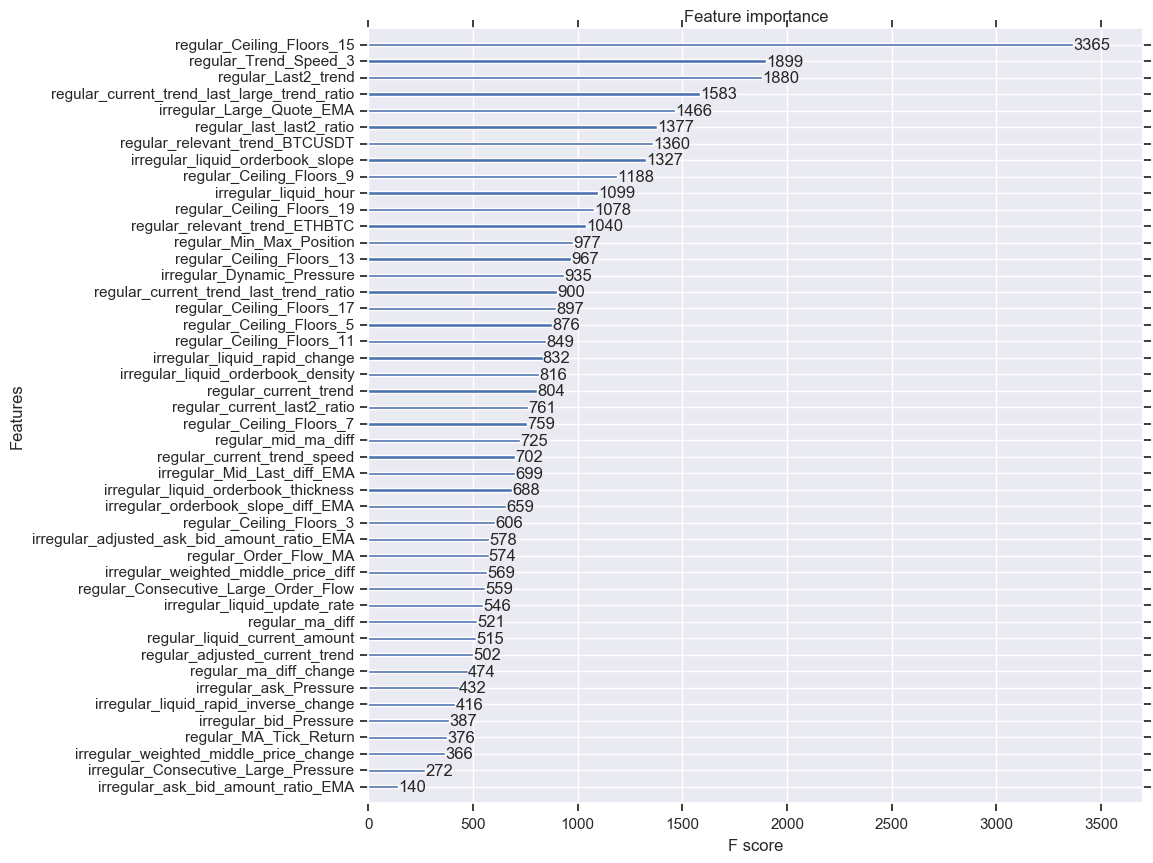

In [29]:
matplotlib.rcParams['figure.dpi'] = 144
matplotlib.rcParams["figure.figsize"] = (10,10)
xgb.plot_importance(bst)
plt.show()

In [ ]:
def xgboostRegressorProcess(dtrain,dval,dtest):

    
    param = {'max_depth': 8, 'eta': 0.1, 'verbosity':2,'subsample':0.5}
    param['nthread'] = 4
    param['eval_metric'] = 'rmse'

    evallist = [(dval, 'eval')]    
    
    num_round = 100
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)
    

    ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    checkAcc(ypred, y_test)
    xgb.plot_importance(bst)
    plt.show()
    

## Extreme Random Forest

In [ ]:
extra_reg = ensemble.ExtraTreesRegressor()
gs = model_selection.GridSearchCV(
    extra_reg,
    {"n_estimators":range(10,101,10), 'min_samples_leaf': range(20,50,5),
    'min_samples_split': range(15,36,5) },
    cv=5,  # 5-fold cross validation
    n_jobs=4,  # run each hyperparameter in one of two parallel jobs
    scoring='r2',
    verbose = 5
)

In [ ]:
gs.fit(X_val[:10000], y_val[:10000])
print ("Best: %f using %s" % (gs.best_score_, gs.best_params_))


In [ ]:
extra_reg =ensemble.ExtraTreesRegressor(min_samples_split=30, n_estimators=40 ,min_samples_leaf= 35, n_jobs=-1,verbose=7)
extra_reg.fit(X_train, y_train)
pre1 = extra_reg.predict(X_test)
checkAcc(pre1, y_test)

In [25]:
extra_reg = ensemble.ExtraTreesRegressor(n_estimators=100,n_jobs=-2,verbose=7)
extra_reg.fit(X_train, y_train)


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100


[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:  1.1min


building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-2)]: Done  26 tasks      | elapsed:  9.3min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100


[Parallel(n_jobs=-2)]: Done  66 tasks      | elapsed: 29.5min


building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=-2)]: Done 100 out of 100 | elapsed: 48.3min finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-2,
          oob_score=False, random_state=None, verbose=7, warm_start=False)

In [26]:
X_test.isnull().values.any()
pre1 = extra_reg.predict(X_test)
checkAcc(pre1, y_test)

[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:   27.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:   42.0s finished


direction prediction accuracy 0.6187051451057252


0.6187051451057252

In [30]:
dic = dict(zip(X_train.columns,extra_reg.feature_importances_))
dicsort = sorted(dic.items(), key = lambda item: item[1], reverse = True)
dicsort

[('irregular_Mid_Last_diff_EMA', 0.22579712090471257),
 ('regular_relevant_trend_ETHBTC', 0.073446089693609329),
 ('regular_mid_ma_diff', 0.040477555136849287),
 ('regular_current_trend_last_large_trend_ratio', 0.038358044733320613),
 ('irregular_liquid_hour', 0.032691957871314535),
 ('regular_Min_Max_Position', 0.02879584056591589),
 ('regular_relevant_trend_BTCUSDT', 0.027217319485319802),
 ('regular_current_trend', 0.024456640813372742),
 ('regular_ma_diff', 0.02422503643967127),
 ('regular_current_trend_last_trend_ratio', 0.020679487731581125),
 ('regular_MA_Tick_Return', 0.020349011712941768),
 ('regular_Last2_trend', 0.020148641335824977),
 ('irregular_weighted_middle_price_diff', 0.019734385753624416),
 ('regular_Trend_Speed_3', 0.019106292758419085),
 ('irregular_weighted_middle_price_change', 0.018691296254152986),
 ('regular_Ceiling_Floors_7', 0.01851612188650963),
 ('regular_Ceiling_Floors_3', 0.017769229196983233),
 ('regular_Ceiling_Floors_5', 0.017232941543198252),
 ('reg